# Hyperplane-Tree Regression Tutorial

Welcome to the tutorial notebook for Hyperplane-Tree. Hyperplane-Tree is a package that can be used to build piecewise linear regression models. These models can be used as objectives or constraints in global optimization problems.

The purpose of this notebook is to introduce the two basic regression models in the package. It will also discuss a few hyperparameters which can be tuned to help improve accuracy, reduce model complexity, and accelerate the fitting process.

## Setup Regression Problem

First we need to set up an example non-linear regression problem. In this example, we will use a nonlinear function to generate data. This data will then be divided into train and test splits. Some noise is also added.

It is not immediately obvious what type of model architecture will best fit this function. As you will see, piecewise linear and quadratic models can easily be trained to fit this function very well.

In [1]:
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200
torch_device = 'cpu'

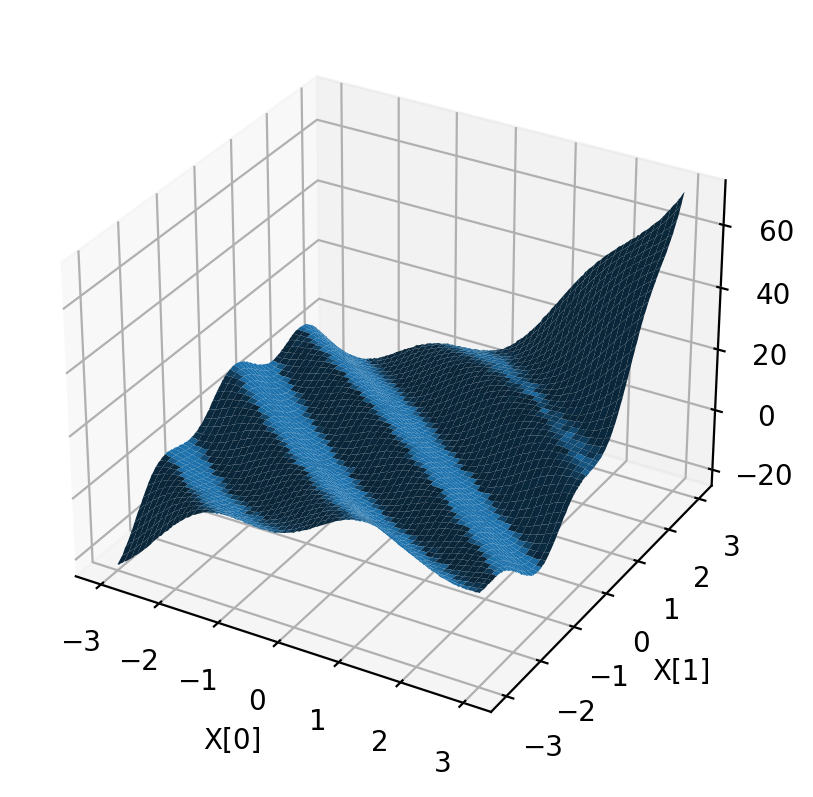

In [2]:
def generate_function(x, y, noise_scale = 0.1):
    a = x/1.3 + y   
    f = a*x*y + a**2 + 4*torch.cos(3*a)
    
    f += torch.normal(mean = torch.zeros_like(x), std = noise_scale)

    return f.to(torch_device)

# Generate sampling points
x0 = torch.linspace(-3, 3, 200, device = torch_device)
x1 = torch.linspace(-3, 3, 200, device = torch_device)
X0, X1 = torch.meshgrid(x0, x1, indexing='ij')

# Generate features and labels tensors
features = torch.vstack((X0.flatten(), X1.flatten())).T.type(torch.float)
y = generate_function(X0, X1).type(torch.float).flatten()

shuffle = torch.randperm(len(y))

train_indices = shuffle[:int(0.8*len(shuffle))]
test_indices = shuffle[int(0.8*len(shuffle)):]

train_features = features[train_indices]
test_features = features[test_indices]
train_y = y[train_indices]
test_y = y[test_indices]

# Plot the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0.cpu(), X1.cpu(), y.reshape(X0.shape).cpu())

ax.set_xlabel('X[0]')
ax.set_ylabel('X[1]')

plt.show()

# Linear Tree Regressor

In [3]:
from systems2atoms.hyperplanetree import LinearTreeRegressor, plot_surrogate_2d
import time

  0%|          | 0/200.0 [00:00<?, ?it/s]

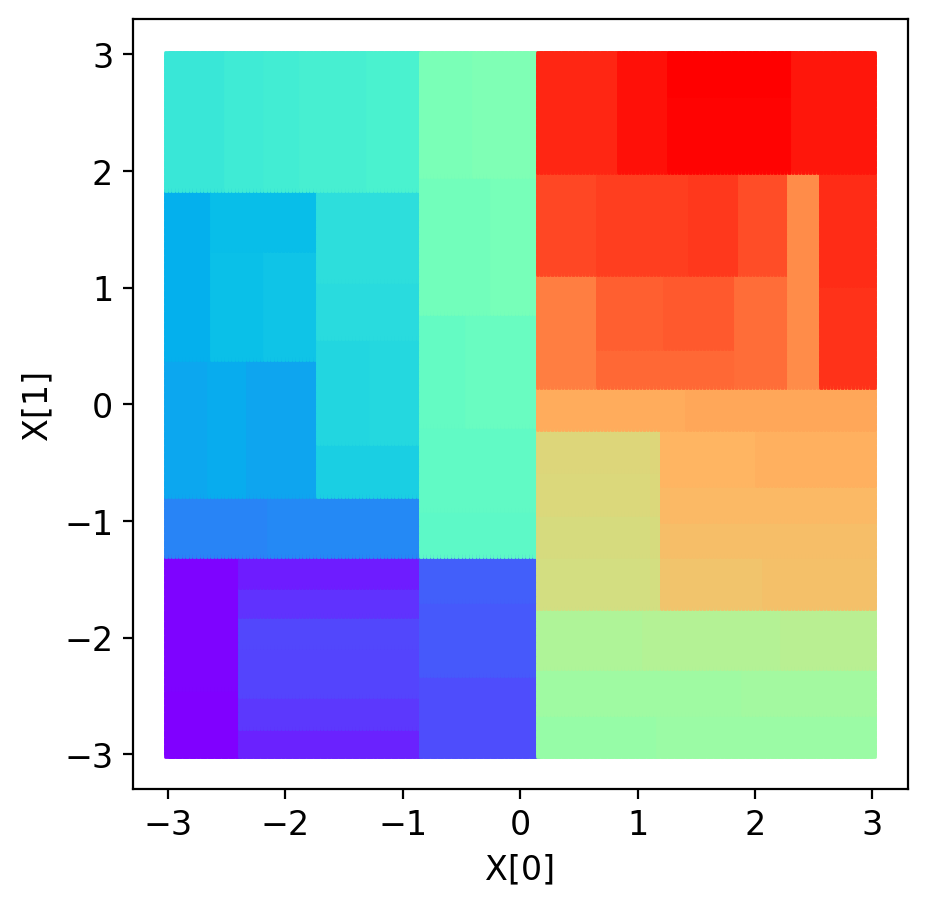

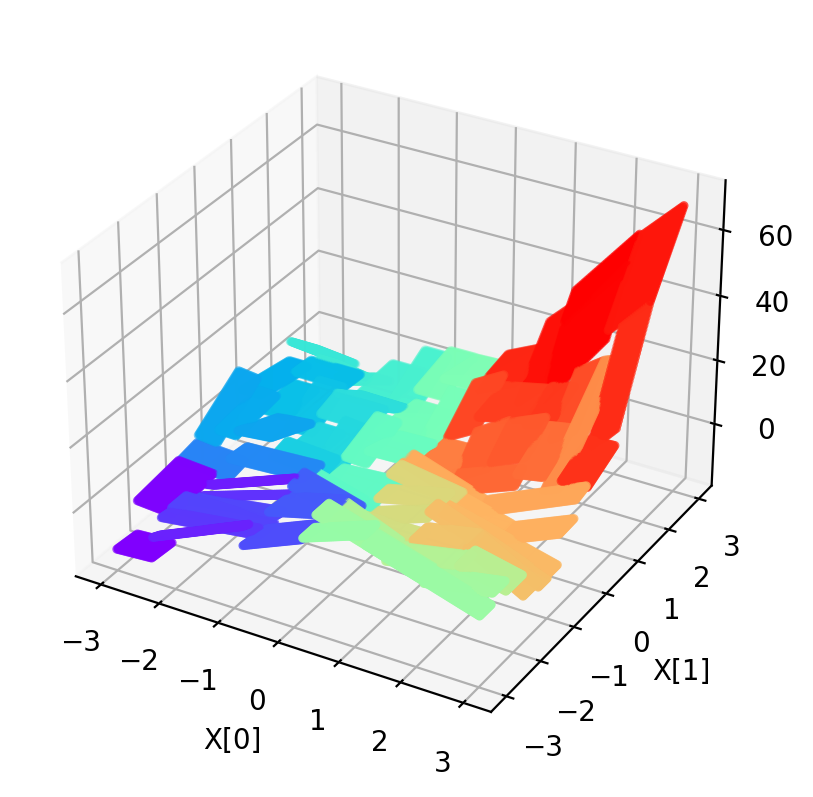

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           74            1.167          11.60


In [4]:
model = LinearTreeRegressor()

t1 = time.time()
model.fit(train_features, train_y)
t2 = time.time()

# For plotting purposes, we can use both train and test data
plot_surrogate_2d(model, features)

# For evaluation, we will only use test data
y_pred = model.predict(test_features.to(torch_device)).cpu()

linear_error = torch.mean(torch.abs(y_pred - test_y))
linear_leaves = model.num_leaves
linear_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves}            {linear_error:.3f}          {linear_time:.2f}')

## Hyperparameter Sweep
That model doesn't look so bad, but let's see what we can do to improve the fit.

The main hyperparameter to control the complexity of the model is `min_samples_leaf`. By default, it is set to `0.01`, meaning each leaf must contain at least 1% of the data. Let's see what happens if we change that:

In [ ]:
import numpy as np
from tqdm.auto import tqdm

min_samples_leaf_vals = np.logspace(-4, -0.5, 10)
numbers_of_leaves = []
train_errors_linear = []
test_errors_linear = []

for min_samples_leaf in tqdm(min_samples_leaf_vals):
    model = LinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        disable_tqdm = False,
    )

    model.fit(train_features, train_y)
    
    numbers_of_leaves.append(model.num_leaves)

    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors_linear.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors_linear.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5333.333333333333 [00:00<?, ?it/s]

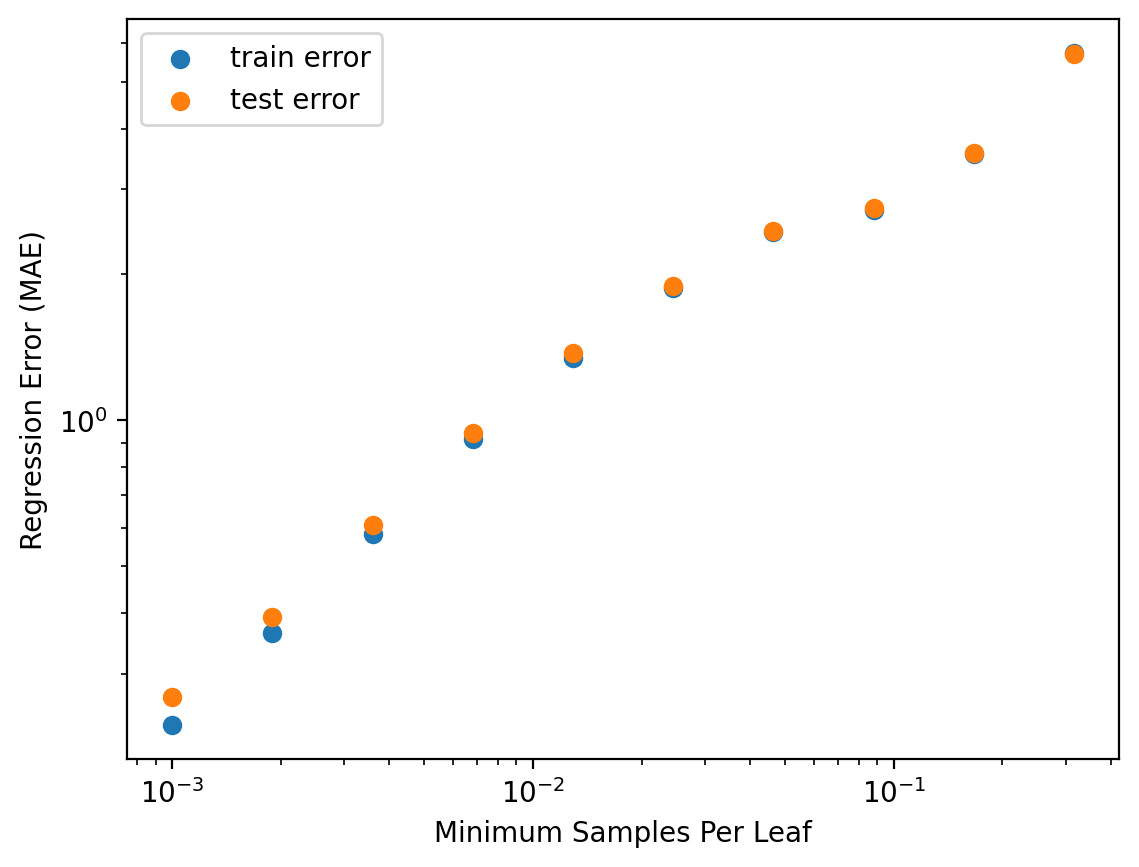

In [ ]:
plt.scatter(min_samples_leaf_vals, train_errors_linear, label = 'train error')
plt.scatter(min_samples_leaf_vals, test_errors_linear, label = 'test error')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('Minimum Samples Per Leaf')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

This looks like a classic hyperparameter optimization problem. Below about 0.1% minimium samples per leaf, the model starts to overfit on this data, and the test error goes up despite decreases in the train error.

Also note that the training time increases as we go to smaller and smaller numbers of samples in the leaves.

Other hyperparamaters which usually have similar behavior include:
- max_depth
- min_samples_split
- min_impurity_decrease (minimum loss improvement to execute a tree split)

For a comprehensive list of all input arguments, please see the docstring:

In [ ]:
?LinearTreeRegressor

Init signature:
LinearTreeRegressor(
    criterion='mae',
    max_depth=inf,
    min_samples_split=6,
    min_samples_leaf=0.01,
    max_bins=25,
    min_impurity_decrease=-inf,
    categorical_features=None,
    split_features=None,
    linear_features=None,
    disable_tqdm=False,
    save_linear_propogation_uncertainty_parameters=False,
    save_quadratic_uncertainty_parameters=False,
    max_batch_size=inf,
    depth_first=True,
)
Docstring:     
A Linear Tree Regressor.

A Linear Tree Regressor is a meta-estimator that combine the learning
ability of Decision Tree and the predictive power of Linear Models.
Like in tree-based algorithms, the received data are splitted according
simple decision rules. The goodness of slits is evaluated in gain terms
fitting linear models in each node. This implies that the models in the
leaves are linear instead of constant approximations like in classical
Decision Tree.

Parameters
----------
criterion : str or Callable, default = 'mae'
    Loss fu

# Hyperplane Tree Regressor

In [ ]:
from systems2atoms.hyperplanetree import HyperplaneTreeRegressor

In [ ]:
model = HyperplaneTreeRegressor()

t1 = time.time()
model.fit(train_features, train_y)
t2 = time.time()

# For plotting purposes, we can use both train and test data
plot_surrogate_2d(model, features)

# For evaluation, we will only use test data
y_pred = model.predict(test_features.to(torch_device)).cpu()

hyperplane_error = torch.mean(torch.abs(y_pred - test_y))
hyperplane_leaves = len(model._leaves)
hyperplane_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves}            {hyperplane_error:.3f}          {hyperplane_time:.2f}')

  0%|          | 0/200.0 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Important Hyperparameters

Two important hyperparameters to be aware of when using `HyperplaneTreeRegressor` are `max_weight` and `num_terms`. These two together control the number and complexity of the hyperplane splits. 

`num_terms` will set the maximum number of terms in the linear combination that defines the hyperplane. With two input dimensions, this should always be 2 or 1 (which should be roughly equivalent to `LinearTreeRegressor`). In higher dimensions, increasing this hyperparameter can dramatically increase the training time and memory requirements, but might lead to better accuracy without reducing actual model size.

`max_weight` will set the maximum weight of each term in the linear combination that defines the hyperplane. All integer weights from `-max_weight` to `max_weight`, inclusive will be considered. Again, increasing this hyperparameter can dramatically increase the training time and memory requirements, but might lead to better accuracy without reducing actual model size.

Notice that when `max_weight` is 1, leaf boundaries are only drawn at 90 and 45 degree angles. On the other hand, when `max_weight` is 5, boundaries can be expressed on many more angles. In this case, there is not a big difference in accuracy between the two settings.

  0%|          | 0/2 [00:00<?, ?it/s]

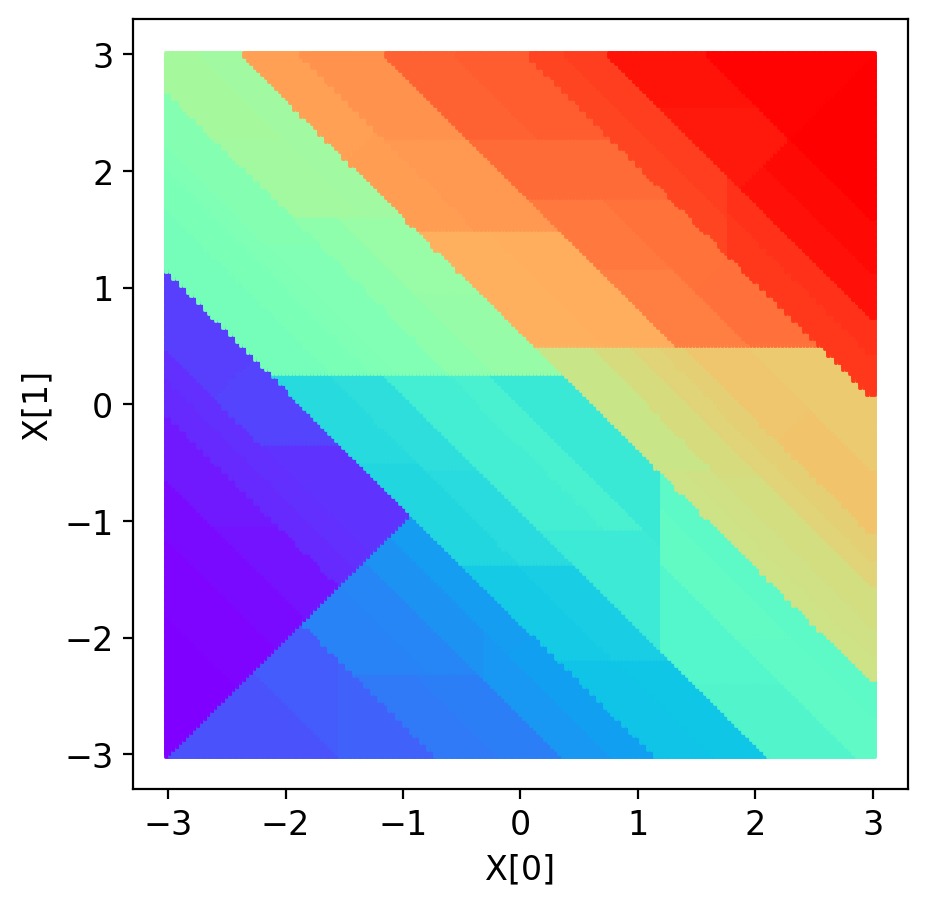

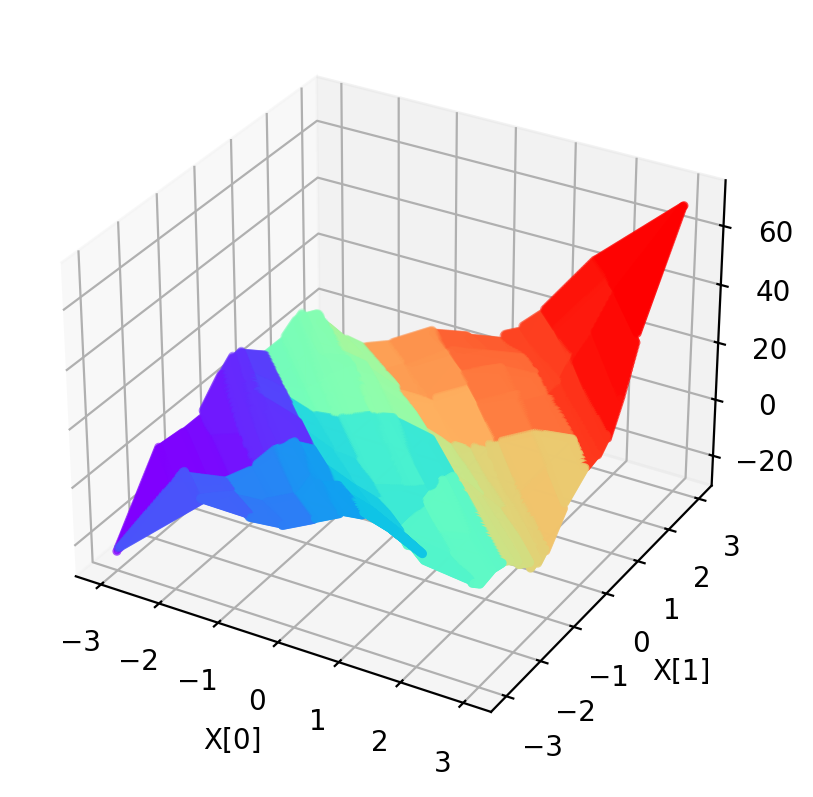

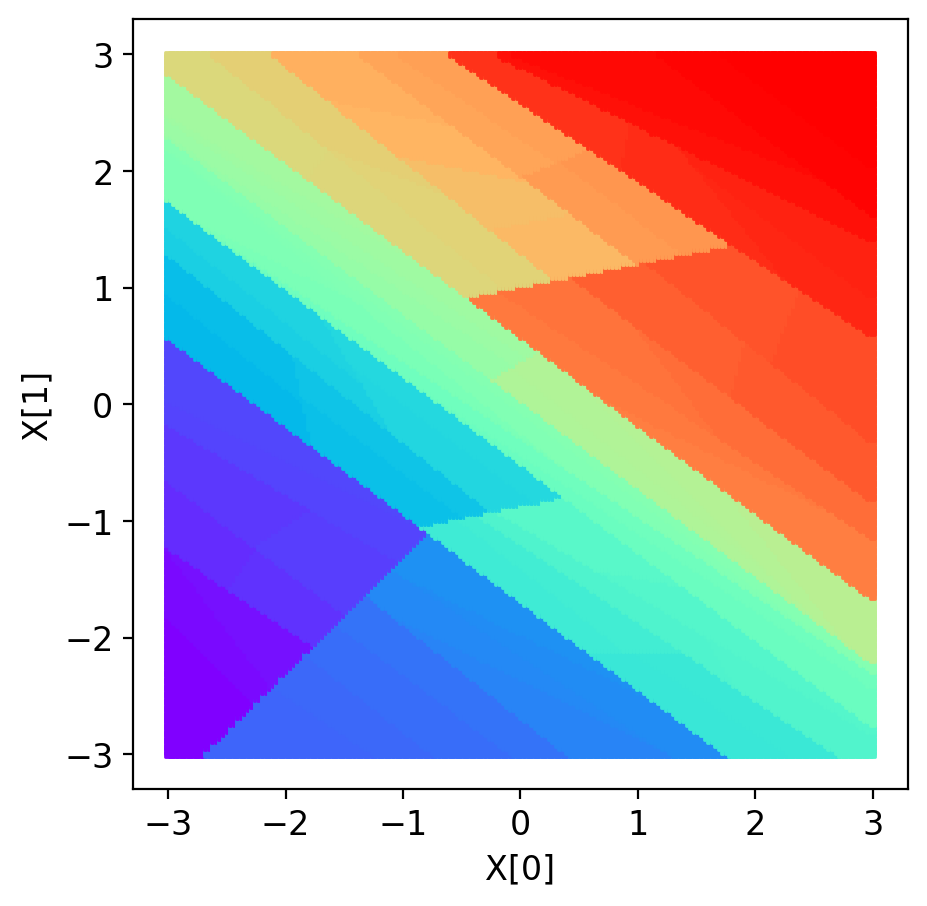

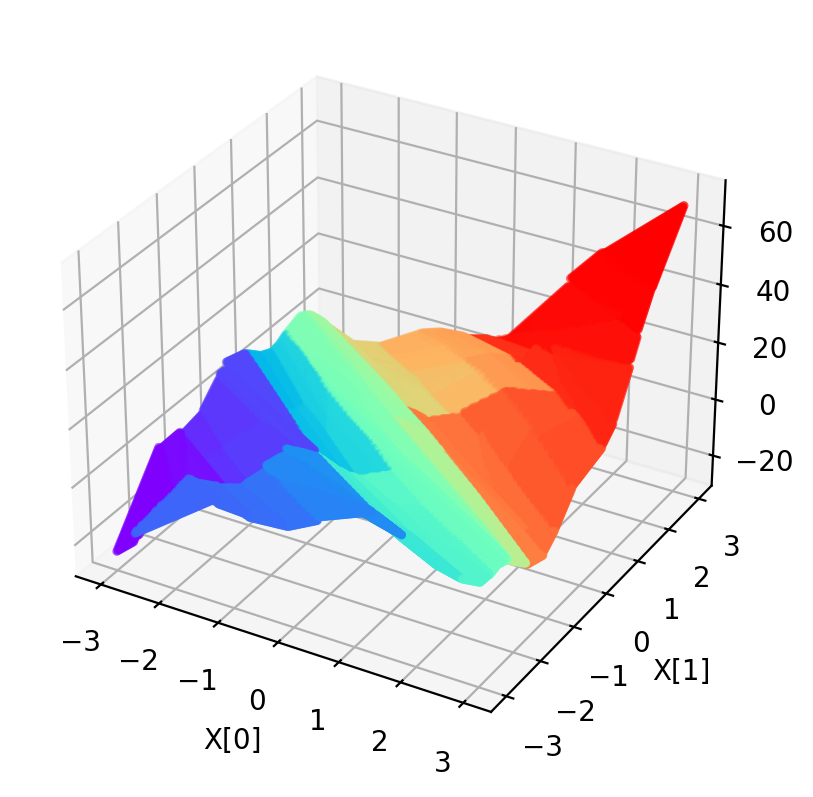

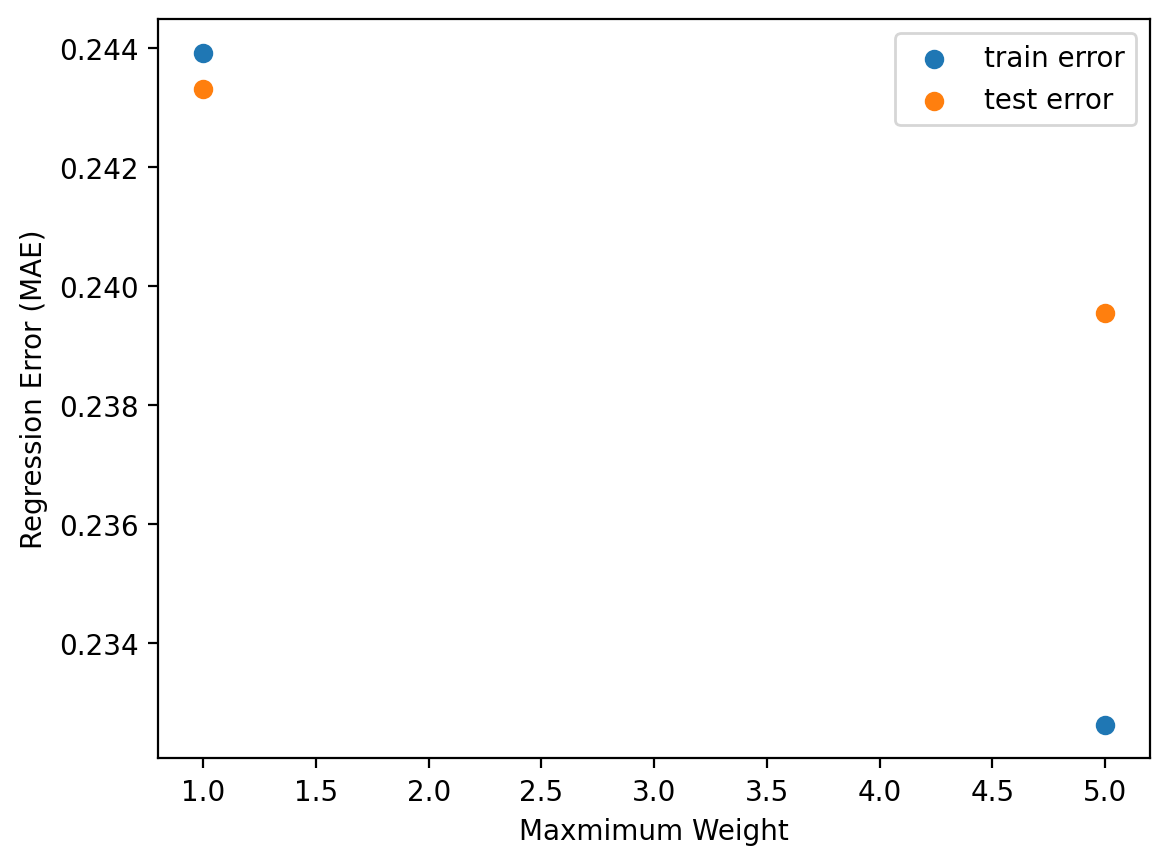

In [ ]:
max_weight_vals = [1, 5]
train_errors = []
test_errors = []

for max_weight in tqdm(max_weight_vals):
    model = HyperplaneTreeRegressor(
        max_weight = max_weight,
        disable_tqdm = False,
    )

    model.fit(train_features, train_y)
    plot_surrogate_2d(model, features)
    
    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))


plt.scatter(max_weight_vals, train_errors, label = 'train error')
plt.scatter(max_weight_vals, test_errors, label = 'test error')

plt.xlabel('Maxmimum Weight')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

In [ ]:
numbers_of_leaves = []
train_errors_hyperplane = []
test_errors_hyperplane = []

for min_samples_leaf in tqdm(min_samples_leaf_vals):
    model = LinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        disable_tqdm = False,
    )

    model.fit(train_features, train_y)
    
    numbers_of_leaves.append(model.num_leaves)

    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors_hyperplane.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors_hyperplane.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))


In [ ]:
plt.scatter(min_samples_leaf_vals, train_errors_hyperplane, label = 'train error')
plt.scatter(min_samples_leaf_vals, test_errors_hyperplane, label = 'test error')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('Minimum Samples Per Leaf')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

In [ ]:
?HyperplaneTreeRegressor

A Hyperplane Tree Regressor.

    A Hyperplane Tree Regressor is a meta-estimator that combine the learning
    ability of Decision Tree and the predictive power of Linear Models.
    Like in tree-based algorithms, the received data are splitted according
    simple decision rules. The goodness of slits is evaluated in gain terms
    fitting linear models in each node. This implies that the models in the
    leaves are linear instead of constant approximations like in classical
    Decision Tree.

    Parameters
    ----------
    min_samples_leaf : int or float, default=0.01
        The recommended parameter to control the size of the tree.
        The minimum number of samples required to be at a leaf node.
        A split point at any depth will only be considered if it leaves at
        least `min_samples_leaf` training samples in each of the left and
        right branches.
        The minimum valid number of samples in each leaf is 3.
        A lower value implies a higher traini

# Conclusions

Here is a table of the overall results, comparing the two regression models. We see error improvement from LinearTree to HyperplaneTree.

In [ ]:
print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves}            {linear_error:.3f}          {linear_time:.2f}')
print(f'Hyperplane Tree:       {hyperplane_leaves}            {hyperplane_error:.3f}          {hyperplane_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           76            0.739          1.19
Hyperplane Tree:       75            0.252          2.84
Quadric Tree:          74            0.175          14.20


In [ ]:
plt.scatter(min_samples_leaf_vals, train_errors_linear, label = 'LinearTree train error')
plt.scatter(min_samples_leaf_vals, test_errors_linear, label = 'LinearTree test error')

plt.scatter(min_samples_leaf_vals, train_errors_hyperplane, label = 'HyperplaneTree train error')
plt.scatter(min_samples_leaf_vals, test_errors_hyperplane, label = 'HyperplaneTree test error')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('Minimum Samples Per Leaf')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

In general, we see about a factor of two accuracy improvement by using hyperplanes vs the classic threshold splits.

The more expressive model also appears to start "overfitting" the data sooner.

This analysis can (and should) be repeated for different underlying functions. When I do this, I almost always see HyperplaneTree performing a little better than LinearTree.

The graph often shows a power law relationship, with the last few data points leveling off at the end in the overfitting regime.